<a href="https://colab.research.google.com/github/Fedryus/Ejercicios-IA/blob/master/SIMPLE-GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imagenes 

In [15]:
import glob

# Importing drive method from colab for accessing google drive
from google.colab import drive
# Mounting drive
# This will require authentication : Follow the steps as guided
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
dataset="/content/drive/My Drive/dataset"
ejemplos="/content/ejemplos"

ERROR! Session/line number was not unique in database. History logging moved to new session 61


In [0]:

import os
from imageio import imread, imwrite
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def cargar_datos():
	print('Creando set de entrenamiento...',end="",flush=True)
	filelist = os.listdir(dataset)

	n_imgs = len(filelist)
	x_train = np.zeros((n_imgs,128,128,3))

	for i, fname in enumerate(filelist):
		if fname != '.DS_Store':
			imagen = imread(os.path.join(dataset,fname))
			x_train[i,:] = (imagen - 127.5)/127.5
	print('¡Listo!')

	return x_train


In [0]:
# Visualizar imágenes del set de entrenamiento
def visualizar_imagen(nimagen,x_train):
	imagen = (x_train[nimagen,:]*127.5) + 127.5
	imagen = np.ndarray.astype(imagen, np.uint8)
	plt.imshow(imagen.reshape(128,128,3))
	plt.axis('off')
	plt.show()

# Generador

In [20]:
import numpy as np
np.random.seed(5)
%tensorflow_version 1.14
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input
from keras.layers.core import Activation
from keras.optimizers import Adam


`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
# Inicialización de parámetros
OPTIMIZADOR = Adam(lr=0.0002, beta_1=0.5)
TAM_ENTRADA = 100
ERROR = 'binary_crossentropy'
LEAKY_SLOPE = 0.2
TAM_LOTE = 128 
N_ITS = 5000

Creando set de entrenamiento...¡Listo!


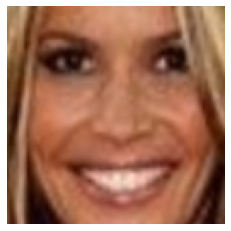

In [26]:
# Crear set de entrenamiento y visualizar una imagen
x_train = cargar_datos()
visualizar_imagen(100,x_train)

In [0]:
def crear_generador():
    modelo = Sequential()
    modelo.add(Dense(1024*4*4, use_bias=False, input_shape=(TAM_ENTRADA,)))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Reshape((4,4,1024)))
    #4x4x1024

    modelo.add(Conv2DTranspose(512,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #8x8x512

    modelo.add(Conv2DTranspose(256,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #16x16x256

    modelo.add(Conv2DTranspose(128,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #32x32x128

    modelo.add(Conv2DTranspose(64,(5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #64x64x64

    modelo.add(Conv2DTranspose(3, (5,5),strides=(2,2),padding='same', use_bias=False))
    modelo.add(Activation('tanh'))
    #128x128x3

    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

generador = crear_generador()
#generador.summary()

# Discriminador

In [0]:
# Discriminador (el inverso del generador)
def crear_discriminador():
    modelo = Sequential()
    modelo.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(128,128,3),
        use_bias=False))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #64x64x64

    modelo.add(Conv2D(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #32x32x128

    modelo.add(Conv2D(256, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #16x16x256

    modelo.add(Conv2D(512, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #8x8x512

    modelo.add(Conv2D(1024, (5,5), strides=(2,2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    #4x4x1024

    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))

    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo

discriminador = crear_discriminador()
#discriminador.summary()

# GAN

In [29]:
# GAN
def crear_GAN(generador, discriminador):
    modelo = Sequential()
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    modelo.compile(optimizer=OPTIMIZADOR, loss=ERROR)

    return modelo
 
gan = crear_GAN(generador, discriminador) 
gan.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 128, 128, 3)       19120576  
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 17436864  
Total params: 36,557,440
Trainable params: 19,085,888
Non-trainable params: 17,471,552
_________________________________________________________________


In [30]:
# Entrenamiento
n_lotes = x_train.shape[0]/TAM_LOTE

for i in range(1,N_ITS+1):
    print("Epoch " + str(i))

    # Crear un "batch" de imágenes falsas y otro con imágenes reales
    ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
    batch_falsas = generador.predict(ruido)

    idx = np.random.randint(low=0, high=x_train.shape[0],size=TAM_LOTE)
    batch_reales = x_train[idx]

    # Entrenar discriminador con imagener falsas y reales, y en cada
    # caso calcular el error
    discriminador.trainable = True

    dError_reales = discriminador.train_on_batch(batch_reales,
        np.ones(TAM_LOTE)*0.9)
    dError_falsas = discriminador.train_on_batch(batch_falsas,
        np.zeros(TAM_LOTE)*0.1)

    discriminador.trainable = False

    # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN
    # como si fuesen imagenes reales
    ruido = np.random.normal(0,1,[TAM_LOTE,TAM_ENTRADA])
    gError = gan.train_on_batch(ruido, np.ones(TAM_LOTE))

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105

In [0]:
# Visualizar imágenes del set de entrenamiento
def visualizar_imagen(nimagen,x_train):
	imagen = (x_train[nimagen,:]*127.5) + 127.5
	imagen = np.ndarray.astype(imagen, np.uint8)
	plt.imshow(imagen.reshape(128,128,3))
	plt.axis('off')
	plt.show()

# Visualización de algunas imagenes obtenidas con el generador
def graficar_imagenes_generadas(epoch, generador, ejemplos=16, dim=(4,4), figsize=(10,10)):
    ruido = np.random.normal(0,1,[ejemplos,100])
    imagenes_generadas = generador.predict(ruido)
    imagenes_generadas.reshape(ejemplos,128,128,3)
    imagenes_generadas = imagenes_generadas*127.5 + 127.5
    plt.figure(figsize=figsize)
    for i in range(ejemplos):
        plt.subplot(dim[0],dim[1], i+1)
        plt.imshow(imagenes_generadas[i].astype('uint8'), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('GAN_imagen_generada_%d.png' %epoch)
    plt.close()

In [0]:
# Generar imágenes ejemplo
def generar_imagenes(generador,nimagenes):
	ruido = np.random.normal(0,1,[nimagenes,100])
	imagenes_generadas = generador.predict(ruido)
	imagenes_generadas.reshape(nimagenes,128,128,3)
	imagenes_generadas = imagenes_generadas*127.5 + 127.5
	imagenes_generadas.astype('uint8')
	for i in range(nimagenes):
		imwrite(os.path.join(ejemplos,'ejemplo_'+str(i)+'.png'),imagenes_generadas[i].reshape(128,128,3))

In [35]:

generar_imagenes(generador,100)